In [565]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sm_tsa
from random import random
pd.set_option('display.max_rows', 10)

In [541]:
df_hospital = pd.read_csv('../data/hospital_visits.csv')
df_hospital['Week'] = df_hospital.Week.map(str) + "-" + df_hospital.Year.map(str)
df_hospital = df_hospital[['Week', 'Total ILI']]
df_hospital.columns = ['Week', 'ILI']
df_hospital = df_hospital[28:256]
df_hospital = df_hospital.reset_index(drop=True)
df_hospital

,Week,ILI
0,15-2015,12311
1,16-2015,11021
2,17-2015,11311
3,18-2015,10946
4,19-2015,9891
...,...,...
223,30-2019,7755
224,31-2019,7851
225,32-2019,8031
226,33-2019,8933


In [542]:
df_twitter = pd.read_csv('../data/twitter-flu-data.csv', header=None)
df_twitter.columns = ['Year', 'Week', '1', '2', '3', '4', '5', '6', '7']
df_twitter['Week'] = df_twitter.Week.map(str) + "-" + df_twitter.Year.map(str)
df_twitter['Tweets'] = df_twitter[['1', '2', '3', '4', '5', '6', '7']].sum(axis=1)
df_twitter = df_twitter[['Week', 'Tweets']][27:-1]
df_twitter = df_twitter.reset_index(drop=True)
df_twitter

,Week,Tweets
0,15-2015,429
1,16-2015,386
2,17-2015,352
3,18-2015,387
4,19-2015,450
...,...,...
223,30-2019,367
224,31-2019,321
225,32-2019,354
226,33-2019,292


In [543]:
df_us = pd.read_csv('../data/USA_flu_virus_counts.csv')
df_us['Week'] = df_us.Week.map(str) + "-" + df_us.Year.map(str)
df_us = df_us[['Week', 'ALL_INF']]
df_us = df_us[786+27:1042]
df_us = df_us.drop(851)
df_us = df_us.reset_index(drop=True)
df_us

,Week,ALL_INF
0,15-2015,1472
1,16-2015,1127
2,17-2015,772
3,18-2015,609
4,19-2015,527
...,...,...
223,30-2019,253
224,31-2019,248
225,32-2019,222
226,33-2019,265


In [675]:
df_aus = pd.read_csv('../data/AUS_flu_virus_counts.csv')
df_aus['Week'] = df_aus.Week.map(str) + "-" + df_aus.Year.map(str)
df_aus = df_aus[['Week', 'ALL_INF']]
df_aus = df_aus[912:1168-27]
df_aus = df_aus.drop(977)
df_aus = df_aus.reset_index(drop=True)
df_aus

,Week,ALL_INF
0,40-2014,72
1,41-2014,58
2,42-2014,29
3,43-2014,28
4,44-2014,24
...,...,...
223,3-2019,125
224,4-2019,97
225,5-2019,110
226,6-2019,106


In [676]:
list_hospital = list(df_hospital['ILI'])
list_tweets = list(df_twitter['Tweets'])
list_us = list(df_us['ALL_INF'])
list_aus = list(df_aus['ALL_INF'])

# list_tweets = [i / 5000 for i in list_tweets]
# list_hospital = [i / 50 for i in list_hospital]
# list_us = [i / 20 for i in list_us]

# list_hospital = [float(i)/sum(list_hospital) for i in list_hospital]
# list_tweets = [float(i)/sum(list_tweets) for i in list_tweets]
# list_us = [float(i)/sum(list_us) for i in list_us]
# list_aus_norm = [float(i)/sum(list_aus) for i in list_aus]

In [677]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(52).mean()
    rolstd = timeseries.rolling(52).std()

    #Plot rolling statistics:
    fig = plt.figure()
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

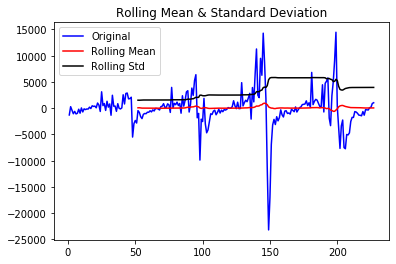

Results of Dickey-Fuller Test:
Test Statistic                  -4.328583
p-value                          0.000396
#Lags Used                       9.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


In [678]:
df_hospital['first_difference'] = df_hospital.ILI - df_hospital.ILI.shift(1)
# df_hospital['first_difference'] = df_hospital.ILI - df_hospital.ILI.shift(52)

# test_stationarity(df.first_difference.dropna(inplace=False))
test_stationarity(df_hospital.first_difference.dropna(inplace=False))

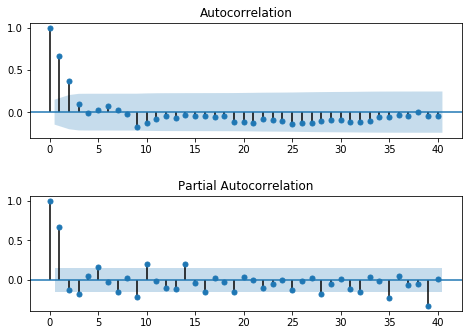

In [679]:
fig = plt.figure()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.5)
ax1 = fig.add_subplot(211)
fig = sm_tsa.plot_acf(df_hospital.first_difference.iloc[53:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm_tsa.plot_pacf(df_hospital.first_difference.iloc[53:], lags=40, ax=ax2)

In [680]:
list_hospital_real = list_hospital[:-52]
list_tweets_real = list_tweets[:-52]
list_us_real = list_us[:-52]
list_aus_real = list_aus[:-52]

list_hospital_pred = list_hospital[-52:]
list_tweets_pred = list_tweets[-52:]
list_us_pred = list_tweets[-52:]
list_aus_pred = list_aus[-52:]

In [681]:
features = [list_tweets_real, list_us_real, list_aus_real]
pred = [list_tweets_pred, list_us_pred, list_aus_pred]

In [682]:
features = list(map(list, zip(*features)))
pred = list(map(list, zip(*pred)))

In [683]:
model = SARIMAX(list_hospital_real, exog=features, order=(1, 1, 0), seasonal_order=(1, 1, 0, 52))
model_fit = model.fit()

In [684]:
# make prediction
future = 52
predictions = model_fit.predict(len(list_hospital_real), len(list_hospital_real) + future - 1, exog=pred)
print(predictions)
future_weeks = list(range(len(list_hospital_real), len(list_hospital_real) + future))
# future_weeks

[ 7737.49706702  7650.31333503  8475.99463919  8576.42687229
  8388.34732389 12710.94130205 13051.3587739  13963.03642994
 15334.07432649 15798.12771564 17158.6735303  18922.94862203
 15961.52679646 18480.29312708 17376.51812794 17132.49450609
 14176.68844669  8713.63457831  6579.22009542  9346.86456388
 16420.79081774 21295.85828383 29310.95020308 31736.11038635
 26360.83668599 18369.12765111 13452.90320398 13144.74904754
 11611.76073503 11680.741563    9783.34878456 10870.3413548
 10137.33175823 10466.4926628  11342.57355035 11146.39260386
 10957.51351354 10884.17452147 10750.06174721 10036.95979829
  9131.35365089  8220.07901015  8088.90761179  7545.53930567
  6902.9670453   6981.61593775  6397.15925316  6290.18431455
  6330.0000787   6440.2993769   7062.94245422  7784.18216475]


In [685]:
predictions_df = pd.DataFrame([future_weeks, predictions]).transpose()
predictions_df.columns = ['Week', 'Total ILI']
predictions_df = predictions_df.set_index('Week')

Text(0.5, 1.0, 'Total ILI + Features: 2014 - 2019')

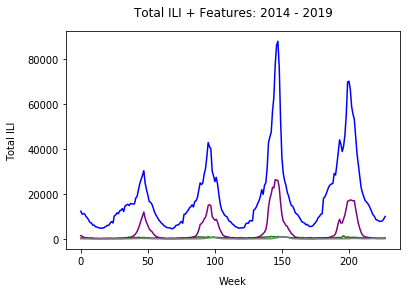

In [686]:
plt.plot(list_hospital, c='blue')
plt.plot(list_tweets, c='green')
plt.plot(list_us, c='purple')
plt.plot(list_aus, c='gray')
# plt.plot(predictions_df, '--', c='#1f77b4')
plt.xlabel("Week", labelpad=10)
plt.ylabel("Total ILI", labelpad=10)
plt.title("Total ILI + Features: 2014 - 2019", pad=15)

Text(0.5, 1.0, 'Total ILI: 2014 - 2019 + predictions')

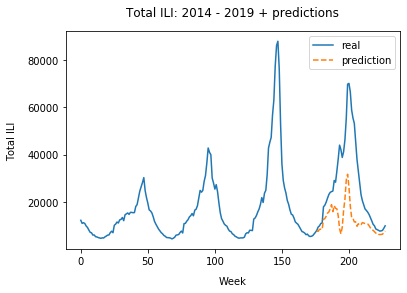

In [687]:
plt.plot(df_hospital['ILI'], label='real')
# plt.plot(predictions_df)
plt.plot(predictions_df, '--', label='prediction')
plt.legend()
plt.xlabel("Week", labelpad=10)
plt.ylabel("Total ILI", labelpad=10)
plt.title("Total ILI: 2014 - 2019 + predictions", pad=15)

In [640]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  176
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 52)   Log Likelihood               -1073.058
Date:                            Mon, 09 Dec 2019   AIC                           2158.115
Time:                                    13:54:20   BIC                           2174.989
Sample:                                         0   HQIC                          2164.969
                                            - 176                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.9445      1.528     -0.618      0.537      -3.940       2.051
x2             2.1517      0.075     28.632      0.000       2.004       2.299
x3             0.7943      2.669      0.298      0.766      -4.437       6.026
ar.L1          0.4951      0.054      9.119      0.000       0.389       0.602
ar.S.L52      -0.0937      0.099     -0.943      0.346      -0.288       0.101
sigma2      2.228e+06   1.93e+05     11.565      0.000    1.85e+06    2.61e+06
===================================================================================
Ljung-Box (Q):                       35.89   Jarque-Bera (JB):               187.75
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               5.45   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""